In [ ]:
# dataset link
#https://www.kaggle.com/datasets/vipoooool/new-plant-diseases-dataset?resource=download

In [1]:
#importing libraries
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import cv2
import numpy as np
#bg remove
from rembg import remove
from PIL import Image

from tensorflow.keras.layers import Dense,Conv2D,MaxPooling2D,Flatten, Dropout, Rescaling, BatchNormalization, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
#backgorund removal
def remove_background(input_path, output_path):
    input_image = Image.open(input_path)
    output_image = remove(input_image)
    
    # Convert to RGB before saving as JPEG
    output_image = output_image.convert("RGB")
    output_image.save(output_path)

In [ ]:
import os
from pathlib import Path

# Set input and output directories
input_dir = 'train'
output_dir = 'train_no_bg'
Path(output_dir).mkdir(parents=True, exist_ok=True)

# Process images
for class_name in os.listdir(input_dir):
    class_path = os.path.join(input_dir, class_name)
    output_class_path = os.path.join(output_dir, class_name)
    Path(output_class_path).mkdir(parents=True, exist_ok=True)

    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        output_img_path = os.path.join(output_class_path, img_name)

        # Remove background
        remove_background(img_path, output_img_path)

print("Background removal completed.")


In [2]:
# #trian image loading #224
train_data = tf.keras.utils.image_dataset_from_directory(
    'train_no_bg',
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(128,128),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 67366 files belonging to 37 classes.


In [3]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.5),  # Rotate images randomly by up to 50% of 360 degrees which is 180
    tf.keras.layers.RandomZoom(0.2)
])

In [4]:
# Apply data augmentation (rotation) to the images
train_data = train_data.map(lambda x, y: (data_augmentation(x), y))

In [5]:
#validation image loading
val_data = tf.keras.utils.image_dataset_from_directory(
    'valid_no_bg',
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(128,128),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 16864 files belonging to 37 classes.


In [6]:
# Apply data augmentation (rotation) to the images
val_data = val_data.map(lambda x, y: (data_augmentation(x), y))

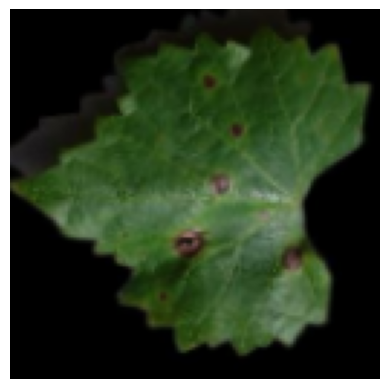

In [11]:
# Get a batch of images and labels
image_batch, label_batch = next(iter(val_data))

# Take the first image from the batch
image = image_batch[0]

# Plot the image
plt.imshow(image.numpy().astype("uint8"))
plt.axis('off')  # Hide axes
plt.show()

In [160]:
#building the model
model = Sequential()

# Add Rescaling Layer as the first layer
model.add(Rescaling(1./255, input_shape=(128, 128, 3)))

# Convolutional Block 1
model.add(Conv2D(filters=32,kernel_size=3,padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))  
model.add(MaxPooling2D(pool_size=2,strides=2))

# Convolutional Block 2
model.add(Conv2D(filters=64,kernel_size=3,padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))  
model.add(MaxPooling2D(pool_size=2,strides=2))

# Convolutional Block 3
model.add(Conv2D(filters=128,kernel_size=3,padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))  
model.add(MaxPooling2D(pool_size=2,strides=2))

# Convolutional Block 4
model.add(Conv2D(filters=256,kernel_size=3,padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))  
model.add(MaxPooling2D(pool_size=2,strides=2))

model.add(Dropout(0.25))

# Fully Connected Layers
model.add(Flatten())
model.add(Dense(units=512, activation='relu'))
model.add(Dropout(0.4))

# Output Layer
model.add(Dense(units=37, activation='softmax')) 

In [161]:
#compiling the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [162]:
#summery of the model
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 batch_normalization_4 (Batc  (None, 128, 128, 32)     128       
 hNormalization)                                                 
                                                                 
 activation_4 (Activation)   (None, 128, 128, 32)      0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 64, 64, 64)       

In [163]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitors validation loss
    patience=3,          # Stops training if val_loss doesn't improve for 3 consecutive epochs
    restore_best_weights=True  # Restores the best weights from the epoch with the lowest val_loss
)

In [164]:
#training the model
training_history = model.fit(x=train_data, validation_data=val_data, epochs=10, verbose=1, callbacks=[early_stopping])

Epoch 1/10
2106/2106 [==============================] - 1003s 471ms/step - loss: 3.1188 - accuracy: 0.1417 - val_loss: 2.5905 - val_accuracy: 0.2514
Epoch 2/10
2106/2106 [==============================] - 765s 362ms/step - loss: 2.3992 - accuracy: 0.2640 - val_loss: 2.5547 - val_accuracy: 0.3034
Epoch 3/10
2106/2106 [==============================] - 748s 354ms/step - loss: 1.8699 - accuracy: 0.4023 - val_loss: 1.6876 - val_accuracy: 0.4931
Epoch 4/10
2106/2106 [==============================] - 848s 401ms/step - loss: 1.4703 - accuracy: 0.5269 - val_loss: 0.8749 - val_accuracy: 0.7250
Epoch 5/10
2106/2106 [==============================] - 732s 346ms/step - loss: 1.0799 - accuracy: 0.6541 - val_loss: 0.5755 - val_accuracy: 0.8143
Epoch 6/10
2106/2106 [==============================] - 733s 347ms/step - loss: 0.8439 - accuracy: 0.7300 - val_loss: 0.8657 - val_accuracy: 0.7355
Epoch 7/10
2106/2106 [==============================] - 743s 352ms/step - loss: 0.6710 - accuracy: 0.7845 - val

In [165]:
#Training accuracy
train_loss, train_acc = model.evaluate(train_data)
print('Training accuracy:', train_acc)

2106/2106 [==============================] - 617s 292ms/step - loss: 0.3751 - accuracy: 0.8770
Training accuracy: 0.8770151138305664


In [166]:
#Validation accuracy
val_loss, val_acc = model.evaluate(val_data)
print('Validation accuracy:', val_acc)

527/527 [==============================] - 116s 216ms/step - loss: 0.3998 - accuracy: 0.8719
Validation accuracy: 0.8719165325164795


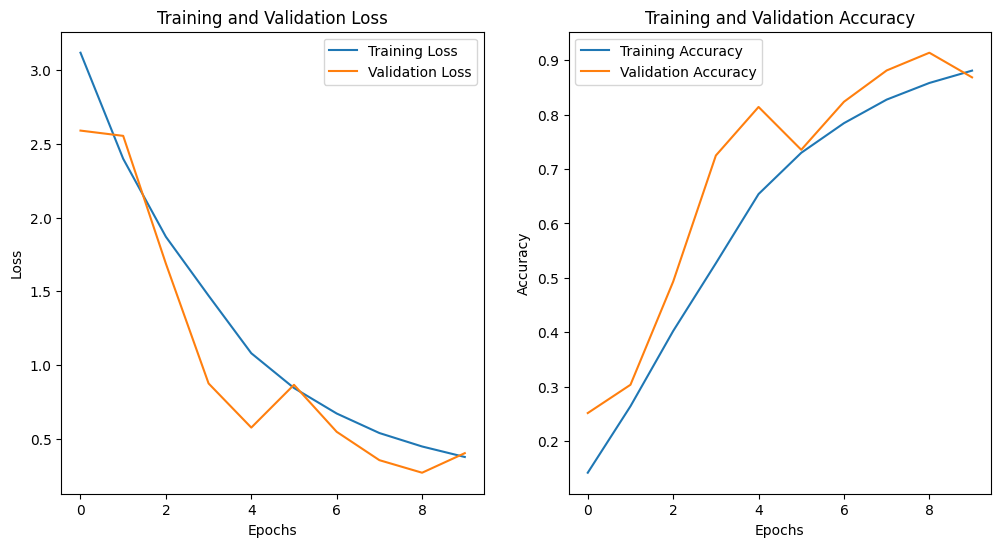

In [167]:
# Plotting training and validation loss
plt.figure(figsize=(12, 6))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(training_history.history['loss'], label='Training Loss')
plt.plot(training_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(training_history.history['accuracy'], label='Training Accuracy')
plt.plot(training_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [171]:
testing_set = tf.keras.utils.image_dataset_from_directory(
    'valid_no_bg',
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(128, 128),
    shuffle=False,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False
)
class_names = testing_set.class_names
print(class_names)

Found 16864 files belonging to 37 classes.
['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Citrus_Canker_Diseases_Leaf', 'Orange___Citrus_Nutrient_Deficiency_Yellow_Leaf_Orange', 'Orange___Haunglongbing_(Citrus_greening)', 'Orange___healthy', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', '

In [172]:
# Apply data augmentation (rotation) to the images
testing_set = testing_set.map(lambda x, y: (data_augmentation(x), y))

In [173]:
predictions = model.predict(testing_set)
predicted_categories = tf.argmax(predictions, axis=1)

527/527 [==============================] - 21s 40ms/step


In [174]:
true_cat = tf.concat([y for x, y in testing_set], axis=0)
true_categories = tf.argmax(true_cat, axis=1)

In [175]:
true_categories.numpy()

array([ 0,  0,  0, ..., 36, 36, 36], dtype=int64)

In [176]:
predicted_categories.numpy()

array([28, 28,  0, ..., 36, 36, 36], dtype=int64)

In [177]:
accuracy = tf.reduce_mean(tf.cast(tf.equal(true_categories, predicted_categories), tf.float32))
print(f'Accuracy: {accuracy.numpy() * 100}%')

Accuracy: 81.41603469848633%


In [178]:
from sklearn.metrics import confusion_matrix,classification_report
cm = confusion_matrix(true_categories,predicted_categories)

In [179]:
# Precision, Recall, & Fscore
print(classification_report(true_categories,predicted_categories,target_names=class_names))

                                                        precision    recall  f1-score   support

                                    Apple___Apple_scab       0.99      0.44      0.61       503
                                     Apple___Black_rot       0.92      0.90      0.91       497
                              Apple___Cedar_apple_rust       0.99      0.78      0.87       431
                                       Apple___healthy       0.64      0.84      0.73       499
              Cherry_(including_sour)___Powdery_mildew       0.98      0.80      0.88       421
                     Cherry_(including_sour)___healthy       0.98      0.87      0.92       456
    Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.64      0.89      0.74       410
                           Corn_(maize)___Common_rust_       0.83      0.89      0.86       384
                   Corn_(maize)___Northern_Leaf_Blight       0.96      0.16      0.27       320
                                Corn_(m

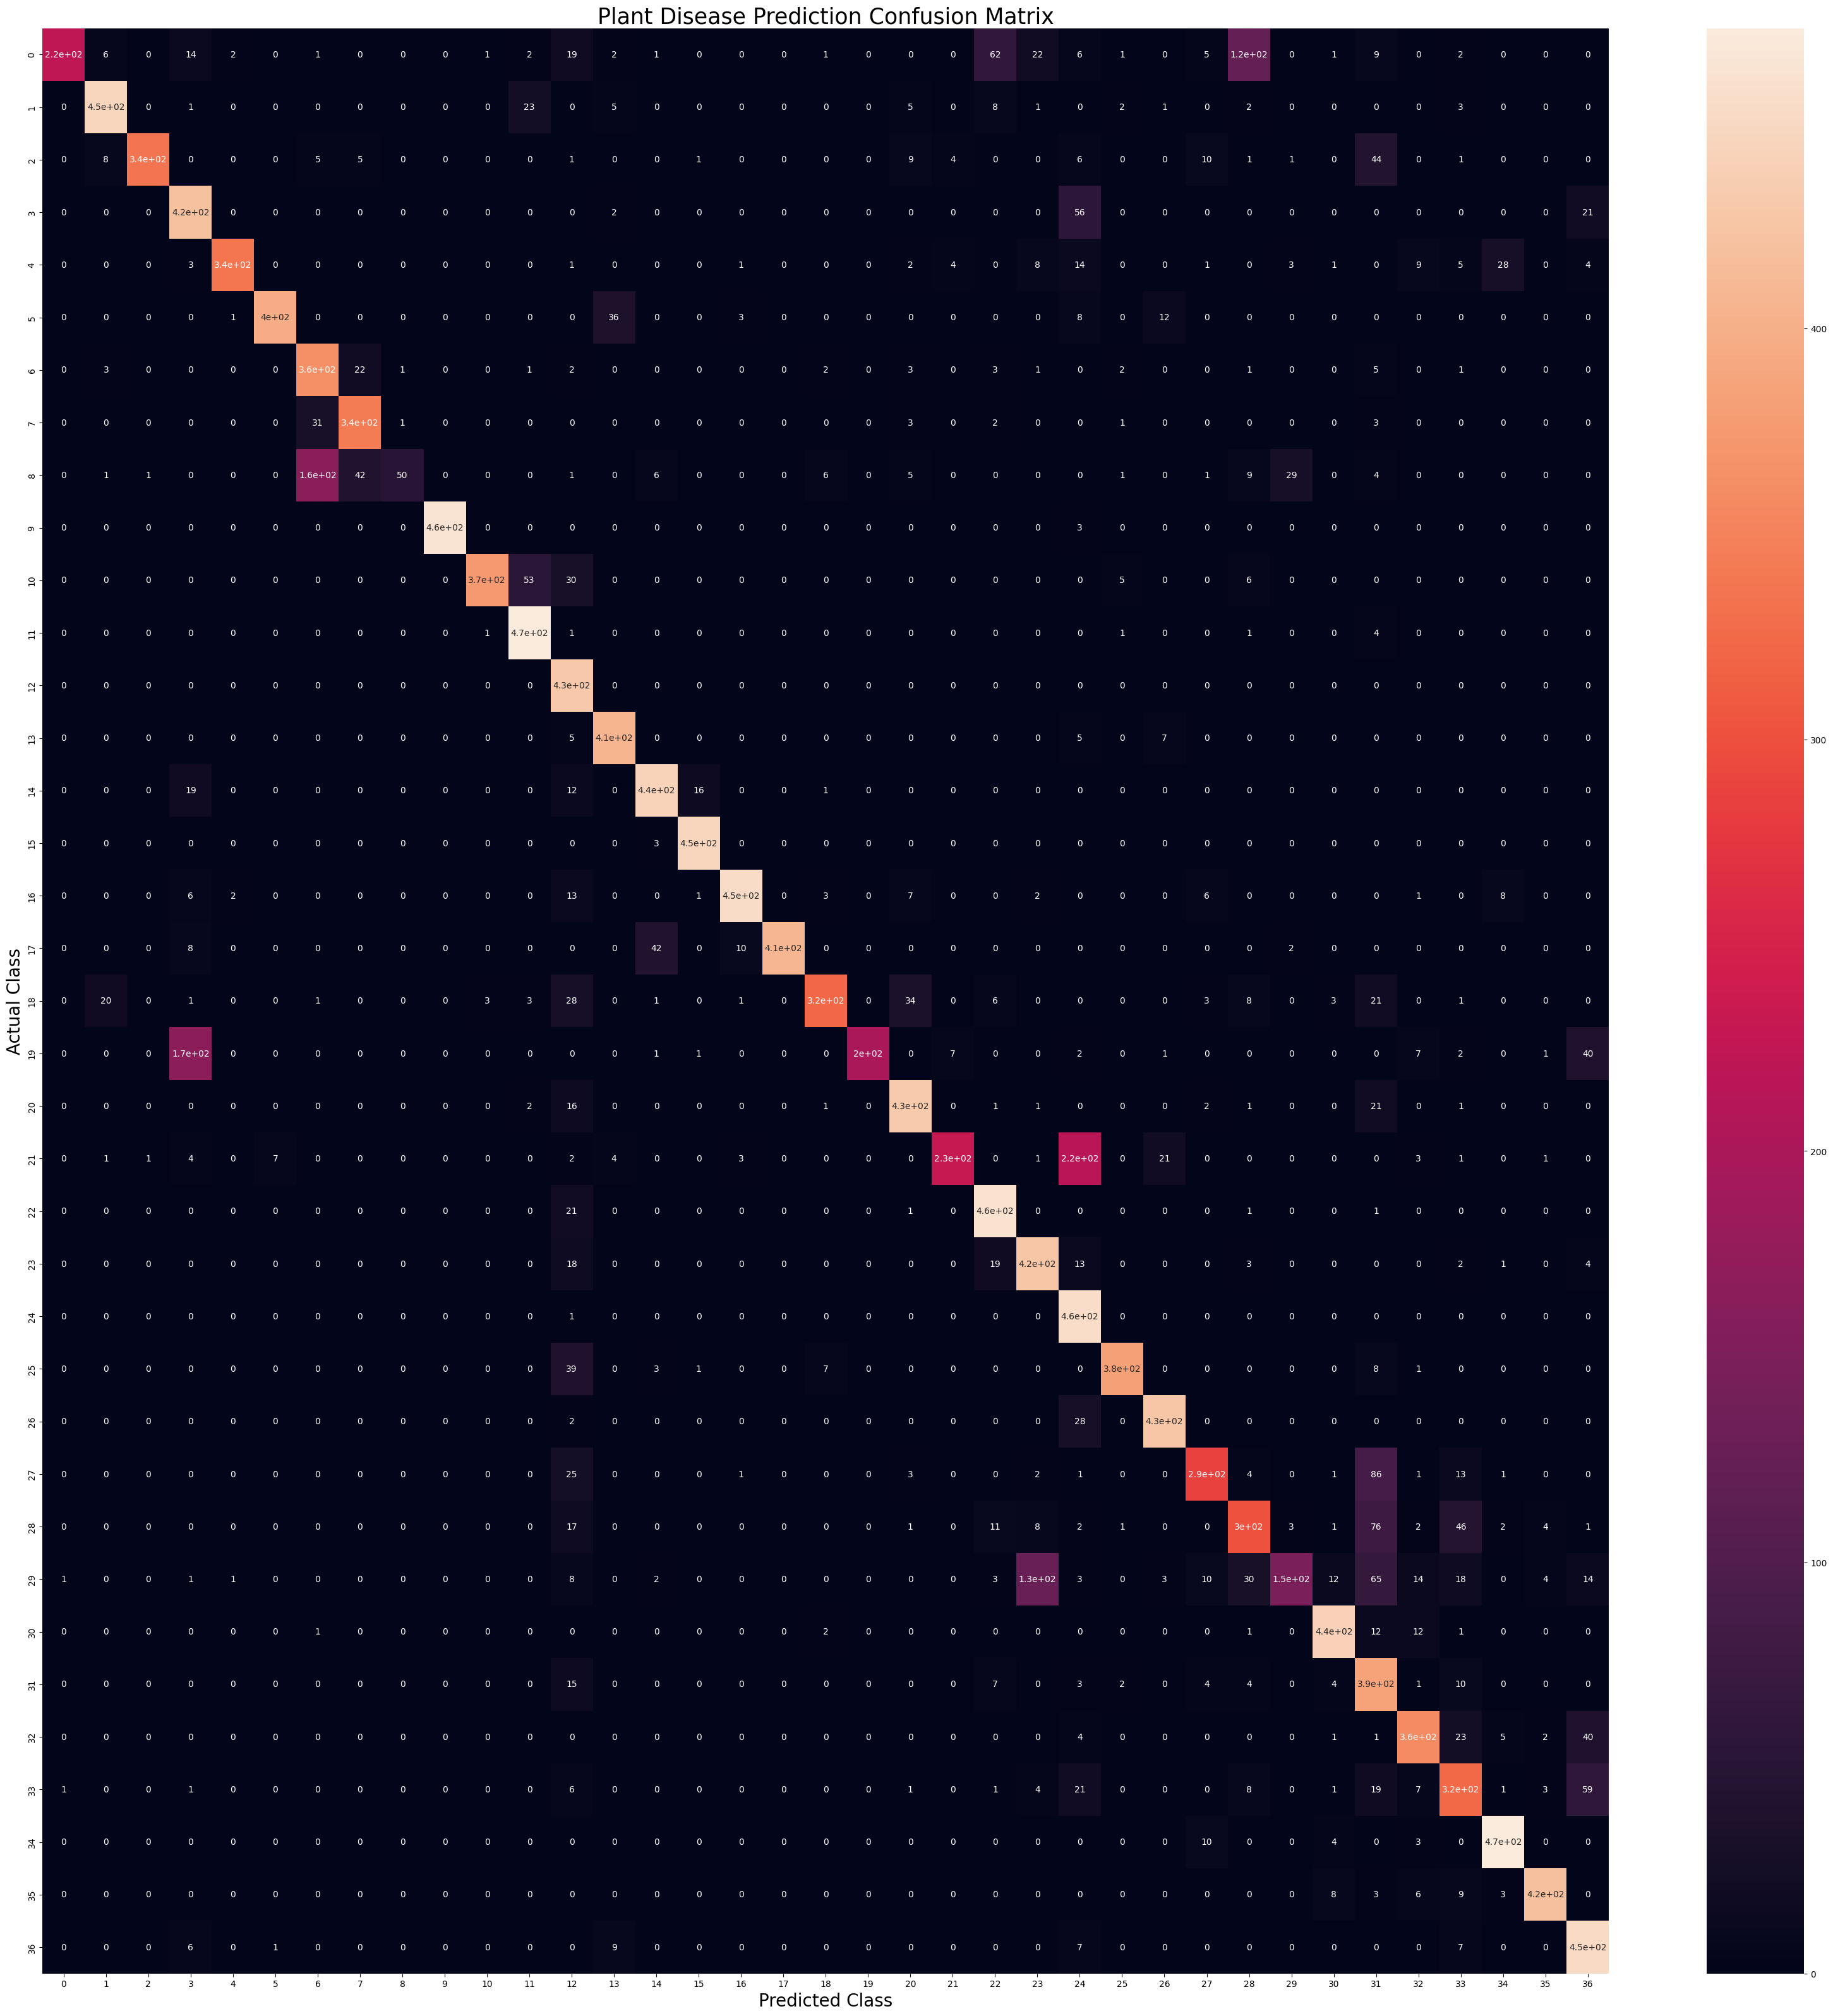

In [180]:
plt.figure(figsize=(40, 40))
sns.heatmap(cm,annot=True,annot_kws={"size": 10})

plt.xlabel('Predicted Class',fontsize = 20)
plt.ylabel('Actual Class',fontsize = 20)
plt.title('Plant Disease Prediction Confusion Matrix',fontsize = 25)
plt.show()

In [181]:
#saving the model
model.save('plant_disease_detection_model.keras')

In [5]:
#libraries for model to run
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import cv2

#bg remove
from rembg import remove
from PIL import Image

In [36]:
# Save class names to a text file
with open('class_names.txt', 'w') as file:
    for class_name in testing_set.class_names:
        file.write(f"{class_name}\n")

In [2]:
#loading the model
cnn_model = tf.keras.models.load_model('plant_disease_detection_model.keras')

In [3]:
# Load class names from the file
with open('class_names.txt', 'r') as file:
    loaded_class_names = [line.strip() for line in file]

print(loaded_class_names)

['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Citrus_Canker_Diseases_Leaf', 'Orange___Citrus_Nutrient_Deficiency_Yellow_Leaf_Orange', 'Orange___Haunglongbing_(Citrus_greening)', 'Orange___healthy', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mi

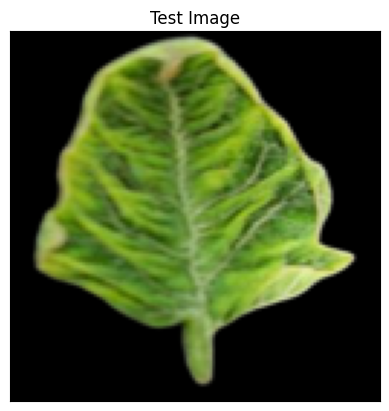

In [168]:
#Test Image Visualization
image_path = 'test/TomatoYellowCurlVirus6.JPG'
# Load the image using PIL
input_image = Image.open(image_path)

# Remove background
output_image = remove(input_image)

# Convert to RGB before displaying
output_image = output_image.convert("RGB")
# Resize to match the model's input shape
img = output_image.resize((128, 128))
# Displaying the image 
plt.imshow(img)
plt.title('Test Image')
plt.xticks([])
plt.yticks([])
plt.show()

In [169]:
input_arr = tf.keras.preprocessing.image.img_to_array(img)
input_arr = np.array([input_arr])  # Convert single image to a batch.
predictions = cnn_model.predict(input_arr)

1/1 [==============================] - 0s 23ms/step


In [171]:
print(predictions)

[[0.0000000e+00 0.0000000e+00 4.5710484e-27 1.8799012e-35 6.0380474e-22
  7.5468990e-31 4.2089004e-32 1.6890623e-38 1.1607527e-34 0.0000000e+00
  0.0000000e+00 0.0000000e+00 6.6192298e-25 4.3433338e-32 0.0000000e+00
  0.0000000e+00 1.7899718e-21 0.0000000e+00 1.1738579e-26 0.0000000e+00
  1.9333134e-18 3.0008521e-22 0.0000000e+00 5.7822585e-24 1.1703961e-35
  4.6213784e-30 1.5893478e-26 2.1202684e-12 3.9865189e-17 7.1863977e-13
  3.1562754e-12 1.3916303e-13 7.5546723e-17 3.0108011e-17 1.0000000e+00
  3.9009395e-15 3.3940779e-27]]


In [172]:
result_index = np.argmax(predictions) #Return index of max element
print(result_index)

34


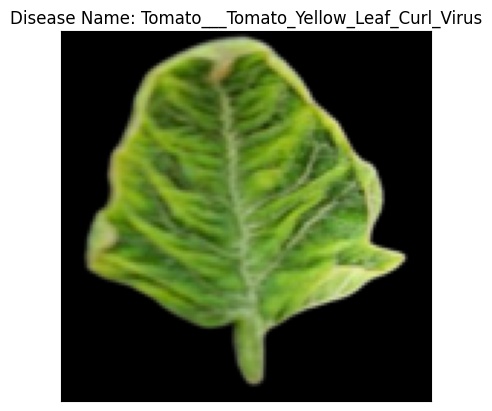

In [173]:
# Displaying the disease prediction
model_prediction = loaded_class_names[result_index]
plt.imshow(img)
plt.title(f"Disease Name: {model_prediction}")
plt.xticks([])
plt.yticks([])
plt.show()